# Some utilities

In [1]:
def analyze_general_info(df):
    # Check the shape of the DataFrame (rows, columns)
    print('\nShape of the DataFrame:\n', df.shape)
    
    analysis = []
    for col in df.columns:
        # Check dtypes
        dtype = df[col].dtype
        # Count NaN values
        num_nan = df[col].isna().sum()
        analysis.append([col, dtype, num_nan])

    df_analysis = pd.DataFrame(analysis, columns=['Column', 'Dtype', 'NumOfNaN'])
    df_analysis.index = [''] * len(df_analysis)  # Set index to empty strings
    display(df_analysis.T)  # transpose the DataFrame before displaying

def analyze_on_RID(df):
    
    print(f"There are in total {len(df['RID'].unique())} unique RIDs.")
    
    # Check dependency
    dependency_check = []
    for column in df.columns:
        is_dependent = df_all.groupby('RID')[column].nunique().max() == 1
        dependency_check.append([column, is_dependent])
        
    df_dependency = pd.DataFrame(dependency_check, columns=['Column', 'IsDependentOnRID'])
    df_dependency.index = [''] * len(df_dependency)  # Set index to empty strings
    display(df_dependency.T)  # transpose the DataFrame before displaying

def analyze_simple_visual(df):
    # Visualizing the distribution of numeric variables
    df.hist(bins=50, figsize=(20,15))
    plt.show()

    # Plotting correlation matrix to understand the relationship between variables
    plt.figure(figsize=(15,15))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
    plt.show()
    
def remove_outliers(df, col):
    # Calculate the 5th and 95th percentiles of the column
    lower = df[col].quantile(0.05)
    upper = df[col].quantile(0.95)

    # Create a mask for values within the desired range
    mask = (df[col] >= lower) & (df[col] <= upper)

    # Return a new DataFrame that only includes rows where the column value is within the desired range
    return df[mask]

def scatter_plot(df, col1, col2, col3=None):
    if col3 is None:
        plt.scatter(df[col1], df[col2])
        plt.title(f'Scatter plot of {col1} vs {col2}')
    else:
        plt.scatter(df[col1], df[col2], c=df[col3], cmap='coolwarm')
        plt.title(f'Scatter plot of {col1} vs {col2} colored by {col3}')
        plt.colorbar(label=col3)
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.show()
    
def scatter_plot_by_category(df, col1, col2, category_col, col3=None):
    df = remove_outliers(df,col1)
    df = remove_outliers(df,col2)
    categories = df[category_col].unique()
    
    for category in categories:
        df_subset = df[df[category_col] == category]
        
        if col3 is None:
            plt.scatter(df_subset[col1], df_subset[col2])
            plt.title(f'Scatter plot of {col1} vs {col2} for {category_col} = {category}')
        else:
            plt.scatter(df_subset[col1], df_subset[col2], c=df_subset[col3], cmap='coolwarm')
            plt.title(f'Scatter plot of {col1} vs {col2} colored by {col3} for {category_col} = {category}')
            plt.colorbar(label=col3)
            
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.show()
        
def violin_plot(df, category_col, value_col):
#     df = remove_outliers(df,value_col)
    sns.violinplot(x=category_col, y=value_col, data=df)
    plt.xlabel(category_col)
    plt.ylabel(value_col)
    plt.title(f'Violin plot of {value_col} grouped by {category_col}')
    plt.show()
    
def plot_ad_ratio(df, col1):
    df = remove_outliers(df, col1).copy()
    
    # Create a new column 'bins' in the DataFrame that indicates which bin each row falls into
    df['bins'] = pd.cut(df[col1], bins=10)
    
    # Group the DataFrame by the 'bins' column and calculate the ratio of "AD" in "DX_bl" for each group
    ad_ratios = df.groupby('bins')['DX_bl'].apply(lambda x: (x == 1).mean())

    # Create the plot
    plt.plot(ad_ratios.index.astype(str), ad_ratios, marker='o')
    plt.xlabel(col1)
    plt.ylabel('Ratio of AD')
    plt.title(f'Ratio of AD in DX_bl for each bin of {col1}')
    plt.xticks(rotation=45)
    plt.show()
    
    # Remove the 'bins' column
    df.drop('bins', axis=1, inplace=True)
    
def plot_ave_in_bins(df, col1, col2):
    df = remove_outliers(df, col1).copy()
    df = remove_outliers(df, col2).copy()
    
    # Create bins based on col1 values
    df['bins'] = pd.cut(df[col1], bins=20)
    
    # Group by the bins and calculate average of col2 values in each bin
    averages = df.groupby('bins')[col2].mean()
    
    # Plot the averages
    plt.figure(figsize=(10, 6))
    plt.plot(averages.index.astype(str), averages.values, marker='o')
    plt.xlabel(col1)
    plt.ylabel('Average of ' + col2)
    plt.title('Average of ' + col2 + ' in bins of ' + col1)
    plt.xticks(rotation=45)
    plt.show()

    # Remove the 'bins' column
    df.drop('bins', axis=1, inplace=True)


# Load and clean data

In [2]:
%load_ext autoreload
%autoreload 2

import os, sys
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthBegin
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.io import write_html, write_image
from datetime import timedelta
from datetime import datetime
import imageio
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from IPython.display import display

In [3]:
# Read data file
df_all = pd.read_csv('ADNI-compact-dataset-2023-0601-orig.csv')

# Convert 'EXAMDATE' to datetime format
df_all['EXAMDATE'] = pd.to_datetime(df_all['EXAMDATE'])

# Sort by 'RID' and 'EXAMDATE'
df_all = df_all.sort_values(['RID', 'EXAMDATE'])

# Replace the 'AGE' column in the original DataFrame with calculated age
df_bl = df_all[df_all['VISCODE'] == 'bl'][['RID', 'EXAMDATE', 'AGE']].rename(columns={'EXAMDATE': 'EXAMDATE_bl', 'AGE': 'AGE_bl'})
df_all = pd.merge(df_all, df_bl, on='RID', how='left')
df_all['AGE_DIFF'] = (df_all['EXAMDATE'] - df_all['EXAMDATE_bl']).dt.days / 365.25
df_all['AGE_NEW'] = df_all['AGE_bl'] + df_all['AGE_DIFF']
df_all['AGE'] = df_all['AGE_NEW'].round(1)
df_all = df_all.drop(columns=['EXAMDATE_bl', 'AGE_bl', 'AGE_DIFF', 'AGE_NEW'])

# Drop the unuseful cloumn
df_all.drop(columns=['Unnamed: 12', 'VISCODE', 'PTETHCAT', 'PTRACCAT', 'PTMARRY'], inplace=True)

# Drop rows with missing values in DX_bl
df_all = df_all.dropna(subset=['DX_bl'])

# Fill some missing values with NA - not applicable
# df_all.fillna({'DX_bl': 'NA', 'PTMARRY': 'NA'}, inplace=True)

# Change categorical values to numerical
df_all['PTGENDER'] = df_all['PTGENDER'].map({'Female': 0, 'Male': 1})
# df_all['APOE4'] = df_all['APOE4'].astype(int)
# df_all['PTEDUCAT'] = df_all['PTEDUCAT'].astype(float)

# Replace the text noted outliers and make sure ABETA values are numeric
# df_all['ABETA'] = df_all['ABETA'].replace({
#     '<200': 100,
#     '>1700': 2000
# })
df_all['ABETA'] = df_all['ABETA'].replace({
    '<200': np.nan,
    '>1700': np.nan
})
df_all['ABETA'] = df_all['ABETA'].astype(float)

# Replace the text noted outliers and make sure TAU values are numeric
# df_all['TAU'] = df_all['TAU'].replace({
#     '<80': 50,
#     '>1300': 150
# })
df_all['TAU'] = df_all['TAU'].replace({
    '<80': np.nan,
    '>1300': np.nan
})
df_all['TAU'] = df_all['TAU'].astype(float)

# Replace the text noted outliers and make sure PTAU values are numeric
# df_all['PTAU'] = df_all['PTAU'].replace({
#     '<8': 0,
#     '>120': 150
# })
df_all['PTAU'] = df_all['PTAU'].replace({
    '<8': np.nan,
    '>120': np.nan
})
df_all['PTAU'] = df_all['PTAU'].astype(float)

# Set the value of PET to 0 if it is negative
df_all.loc[df_all['PET-CL'] < 0, 'PET-CL'] = 0

# Save the cleaned data as .csv file
df_all.to_csv('temp_clean.csv', index=False)

In [4]:
analyze_general_info(df_all)


Shape of the DataFrame:
 (16334, 17)


,,,,,,,,,,,,,,,,,
Column,RID,EXAMDATE,DX_bl,AGE,PTGENDER,PTEDUCAT,APOE4,FDG,PET-CL,ABETA,TAU,PTAU,CDRSB,ADAS11,ADAS13,ADASQ4,MMSE
Dtype,int64,datetime64[ns],object,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
NumOfNaN,0,0,0,9,0,0,336,12643,12745,14316,13973,13977,4641,4949,5050,4914,4916


In [5]:
# Calculate the "average" rate of change of cognitive scores
roc_column_names = ['RID'] + [f'{col}_roc' for col in df_all.columns[-10:]]
df_roc = pd.DataFrame(columns=roc_column_names)

# All unique RIDs
unique_rids = df_all['RID'].unique()

# For each RID, calculate the rate of change for each of the last 10 columns
for rid in unique_rids:
    df_rid = df_all[df_all['RID'] == rid].sort_values('EXAMDATE')

    # Convert EXAMDATE to the number of days from the earliest date
    df_rid['EXAMDATE'] = (df_rid['EXAMDATE'] - df_rid['EXAMDATE'].min()).dt.days / 180

    # Initialize a dictionary to hold the rate of change for each column
    roc_dict = {'RID': rid}

    for col in df_all.columns[-10:]:
        # Check if the DataFrame has less than two rows for the current column
        if len(df_rid[df_rid[col].notnull()]) < 2:
            roc_dict[f'{col}_roc'] = np.nan
            continue

        # # Drop rows with NaN
        df_rid_col = df_rid.dropna(subset=[col])

        # Linear regression
        X = df_rid_col['EXAMDATE'].values.reshape(-1, 1)  # Features
        y = df_rid_col[col].values  # Target

        model = LinearRegression()
        model.fit(X, y)

        # Get the slope (rate of change)
        roc_dict[f'{col}_roc'] = model.coef_[0]

    # Save the rates of change in df_roc
    df_roc = pd.concat([df_roc, pd.DataFrame([roc_dict])], ignore_index=True)

# Reset index of df_roc
df_roc.reset_index(drop=True, inplace=True)
# df_roc['RID'] = df_all['RID'].astype(int)

In [6]:
# group by RID and aggregate
df_agg = df_all.groupby('RID').agg({col: ('mean' if df_all[col].dtype == 'float64' else 'first') 
                                    for col in df_all.columns})

df_agg.reset_index(drop=True, inplace=True)

# merge df_roc to df_agg
if df_agg['RID'].duplicated().any() or df_roc['RID'].duplicated().any():
    print("Duplicate 'RID' values found. Please make sure 'RID' is unique in both dataframes.")
else:
    df_plot = df_agg.merge(df_roc, on='RID')
    
# Apply the round function to each float column
float_cols = df_plot.select_dtypes(include='float64').columns
df_plot[float_cols] = df_plot[float_cols].apply(lambda x: x.round(3))

# Replace diagnosis with numbers
df_plot['DX_bl'] = df_plot['DX_bl'].replace({
    'CN': 0,
    'SMC': 1,
    'EMCI': 2,
    'LMCI': 3,
    'AD': 4
})
df_plot['DX_bl'] = df_plot['DX_bl'].astype(int)

# Save the aggregated data as .csv file
df_plot.to_csv('temp_aggregate.csv', index=False)

In [7]:
analyze_general_info(df_plot)


Shape of the DataFrame:
 (2416, 27)


,,,,,,,,,,,...,,,,,,,,,,
Column,RID,EXAMDATE,DX_bl,AGE,PTGENDER,PTEDUCAT,APOE4,FDG,PET-CL,ABETA,...,FDG_roc,PET-CL_roc,ABETA_roc,TAU_roc,PTAU_roc,CDRSB_roc,ADAS11_roc,ADAS13_roc,ADASQ4_roc,MMSE_roc
Dtype,object,datetime64[ns],int32,float64,int64,int64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
NumOfNaN,0,0,0,4,0,0,207,799,734,1324,...,1558,1428,1842,1736,1738,298,333,338,332,332


# Model simulation

In [8]:
# Parameters in "Towards the integrative theory of Alzheimer’s disease: linking molecular mechanisms of neurotoxicity, beta-amyloid biomarkers, and the diagnosis"
S = 291.5
F = 37.6
Kexc = 0.5

In [9]:
df_plot['Ku_Ka'] = S / df_plot['ABETA'] * 1000 - F - df_plot['PET-CL']

In [10]:
# Calculate the argument of the log function
argument = 1 + df_plot['PET-CL'] / df_plot['Ku_Ka'] / Kexc

# Check if the argument is NaN
is_nan = np.isnan(argument)

# Assign NaN to 'TOX' where the argument is not greater than zero or is NaN
df_plot['TOX'] = np.where((argument > 0) & ~is_nan, df_plot['Ku_Ka'] * np.log(argument), np.nan)


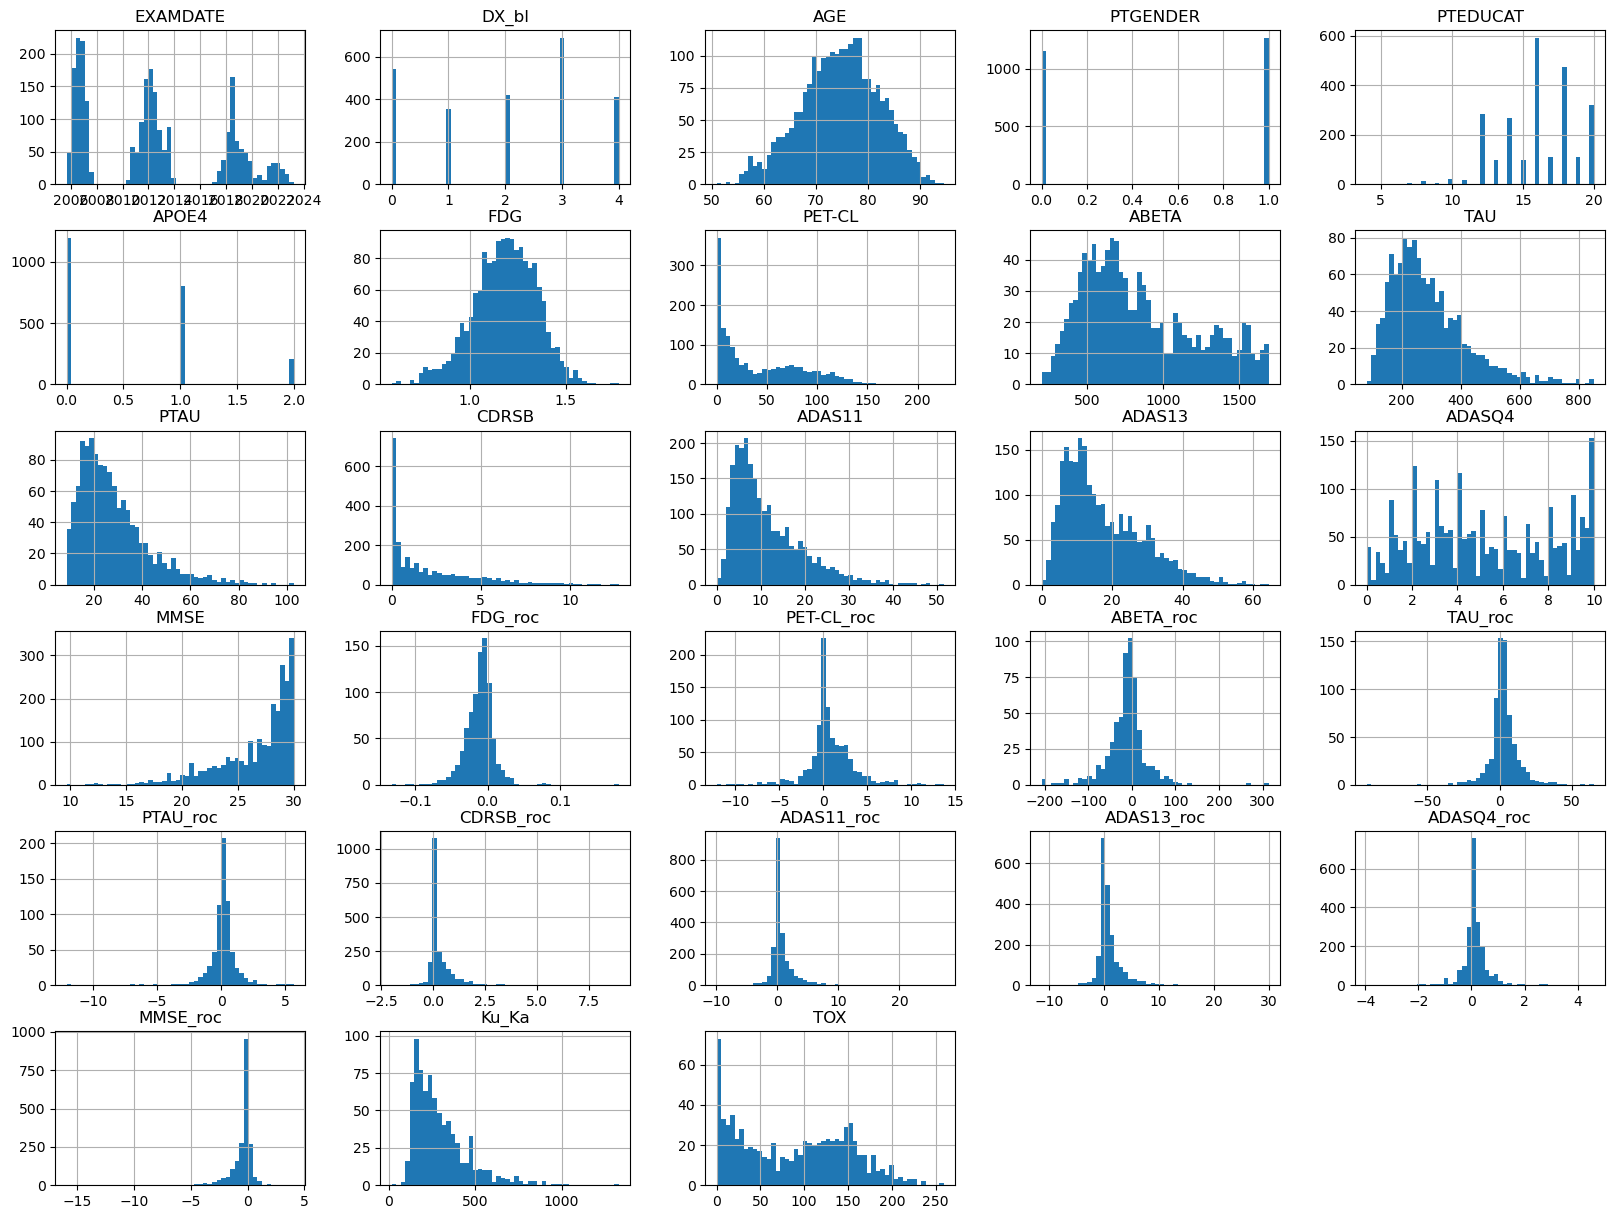

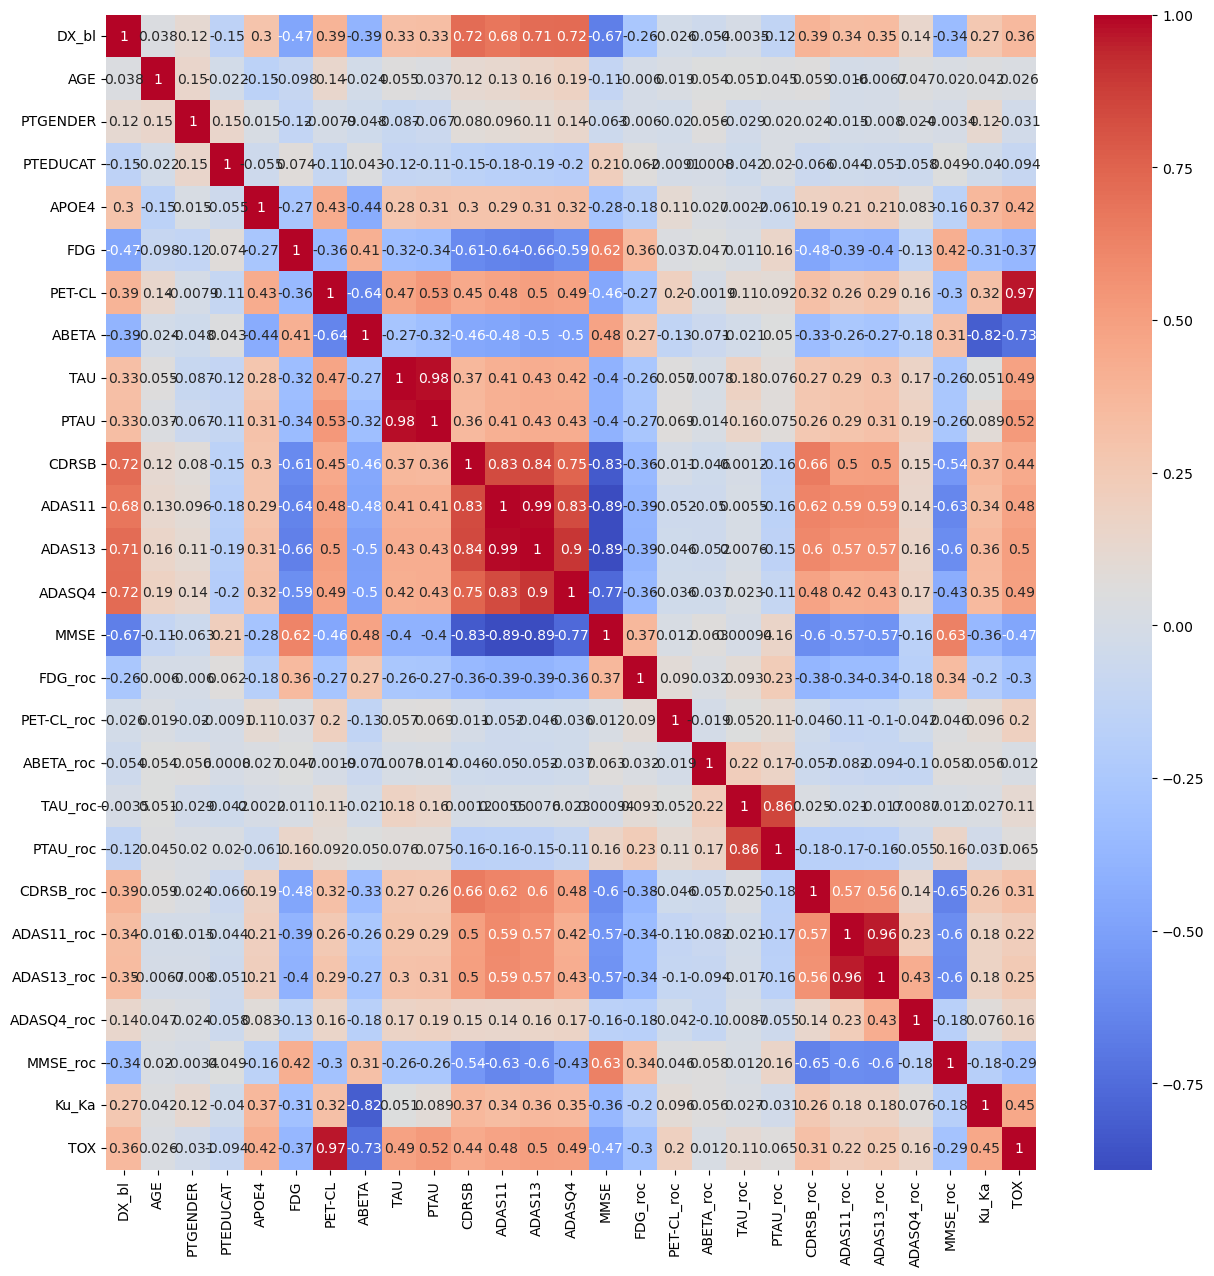

In [11]:
analyze_simple_visual(df_plot)

# Cog_roc v.s. TOX

In [12]:
def plot_ave_in_bins(df, col1, col2):
    df = remove_outliers(df, col1).copy()
    df = remove_outliers(df, col2).copy()
    
    # Create bins based on col1 values
    df['bins'] = pd.cut(df[col1], bins=20)
    
    # Group by the bins and calculate average of col2 values in each bin
    averages = df.groupby('bins')[col2].mean()
    
    # Plot the averages
    plt.figure(figsize=(10, 6))
    plt.plot(averages.index.astype(str), averages.values, marker='o')
    plt.xlabel(col1)
    plt.ylabel('Average of ' + col2)
    plt.title('Average of ' + col2 + ' in bins of ' + col1)
    plt.xticks(rotation=45)
    plt.show()

    # Remove the 'bins' column
    df.drop('bins', axis=1, inplace=True)

def plot_med_in_bins(df, col1, col2):
    df = remove_outliers(df, col1).copy()
    df = remove_outliers(df, col2).copy()
    # Create bins based on col1 values
    df['bins'] = pd.cut(df[col1], bins=15)
    
    # Group by the bins and calculate median of col2 values in each bin
    medians = df.groupby('bins')[col2].median()
    
    # Plot the medians
    plt.figure(figsize=(10, 6))
    plt.plot(medians.index.astype(str), medians.values, marker='o')
    plt.xlabel(col1)
    plt.ylabel('Median of ' + col2)
    plt.title('Median of ' + col2 + ' in bins of ' + col1)
    plt.xticks(rotation=45)
    plt.show()

    # Remove the 'bins' column
    df.drop('bins', axis=1, inplace=True)

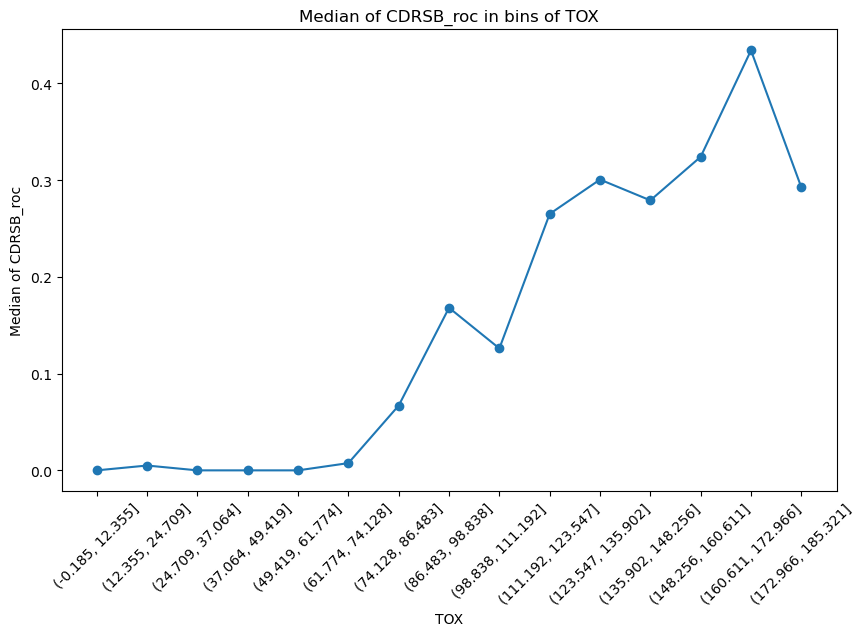

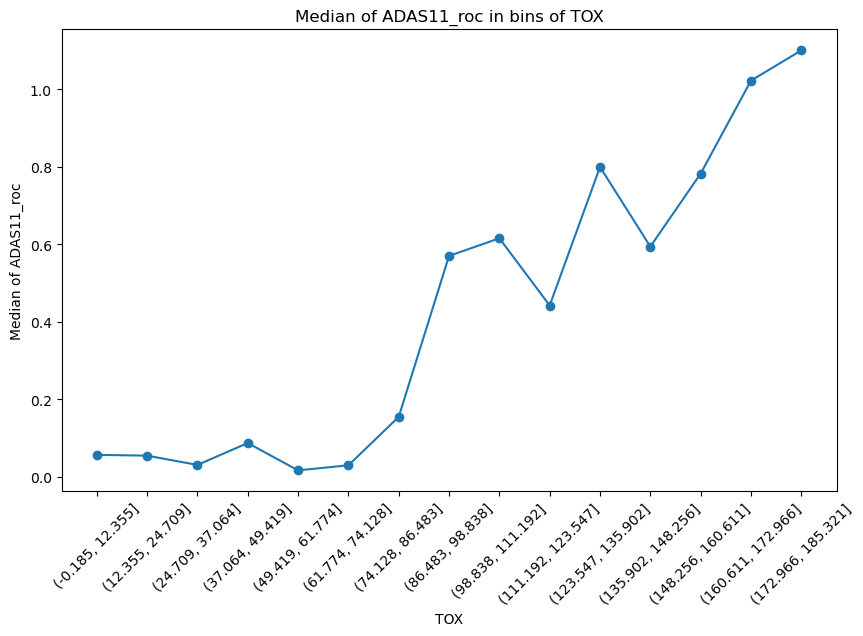

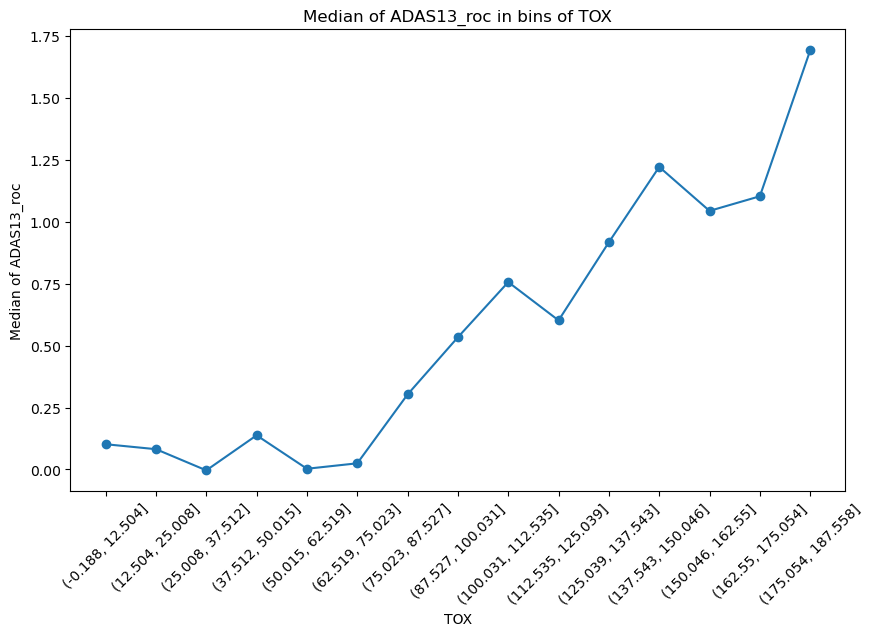

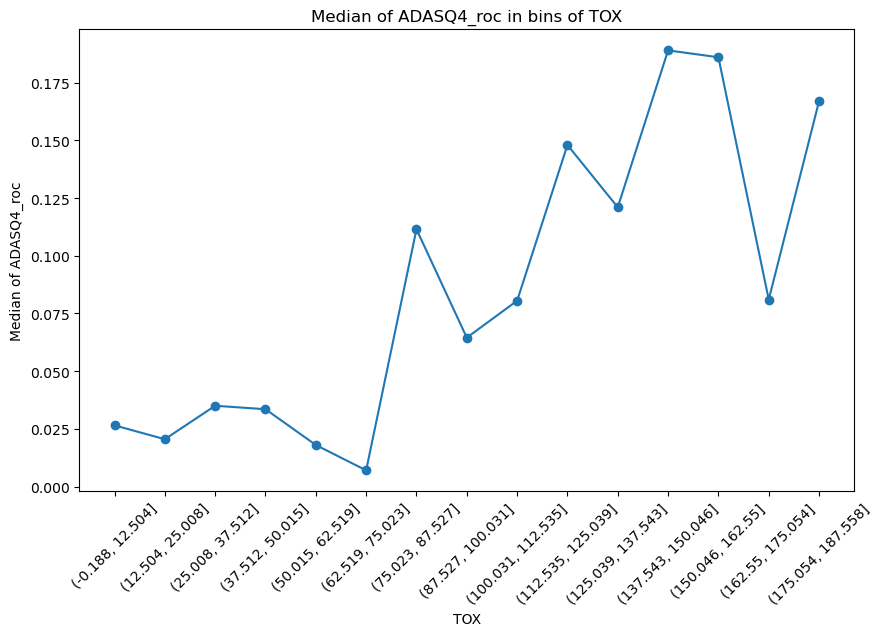

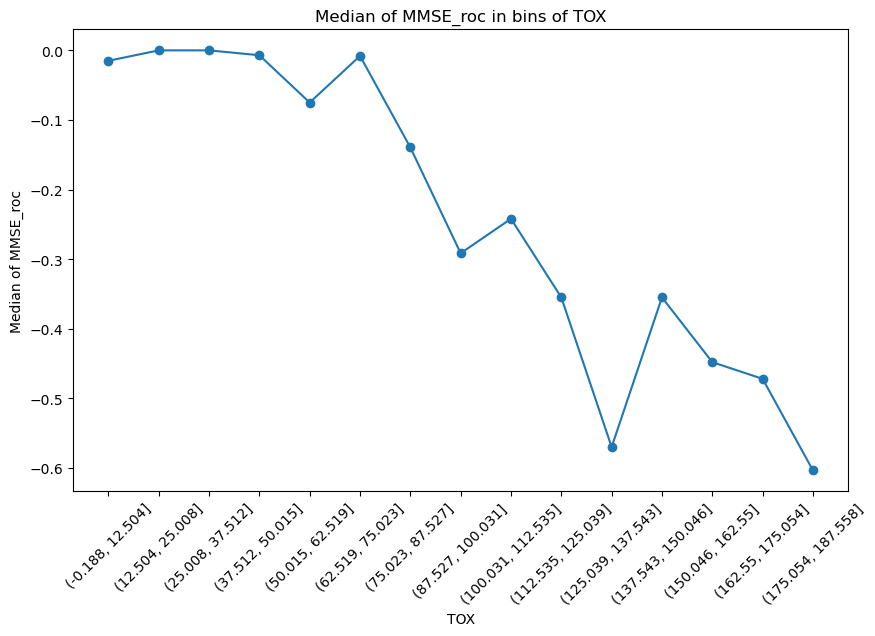

In [13]:
# Get a list of all columns that end with "_roc"
roc_columns = [col for col in df_plot.columns if col.endswith('_roc')]

# Keep only the last five columns
roc_columns = roc_columns[-5:]

# Loop over the roc_columns and plot medians in bins for each one
for col in roc_columns:
    plot_med_in_bins(df_plot, 'TOX', col)

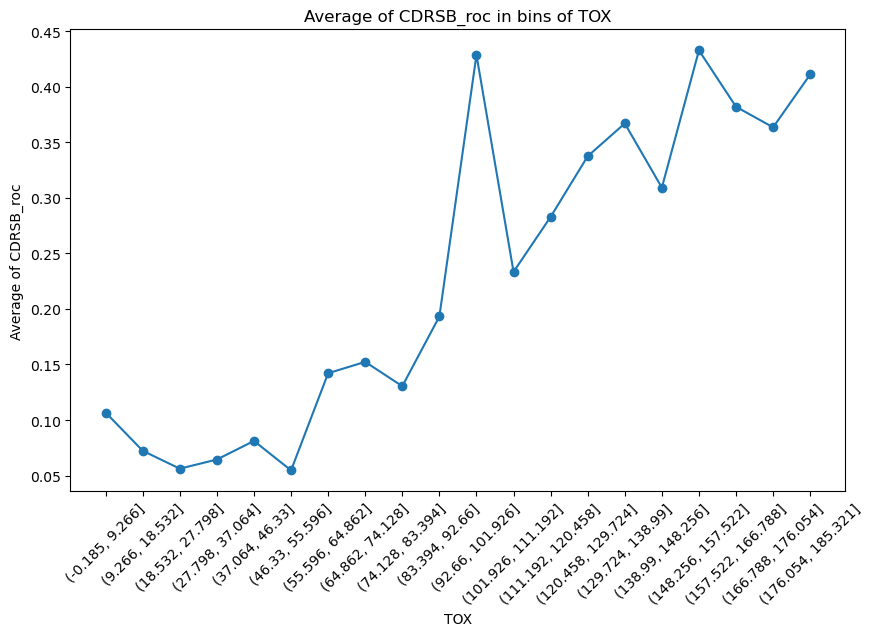

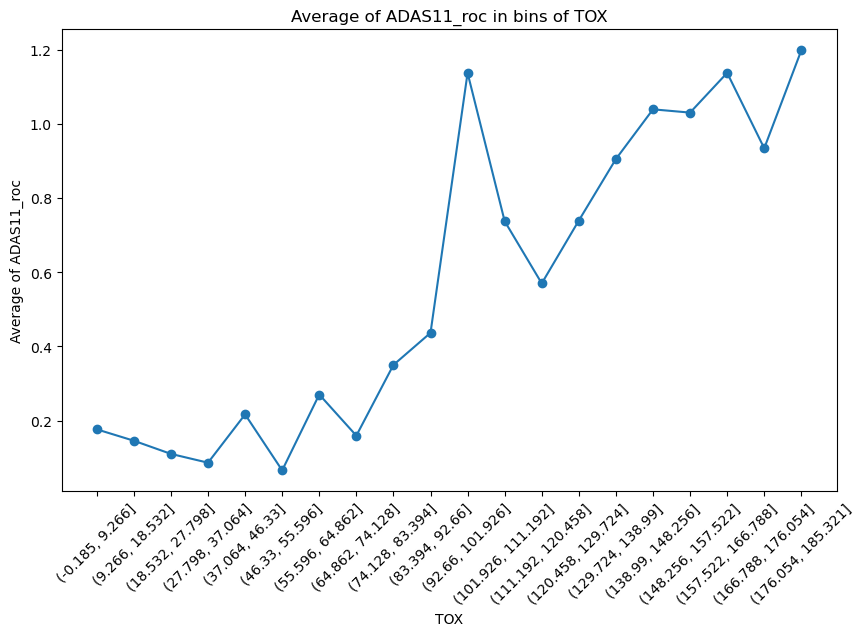

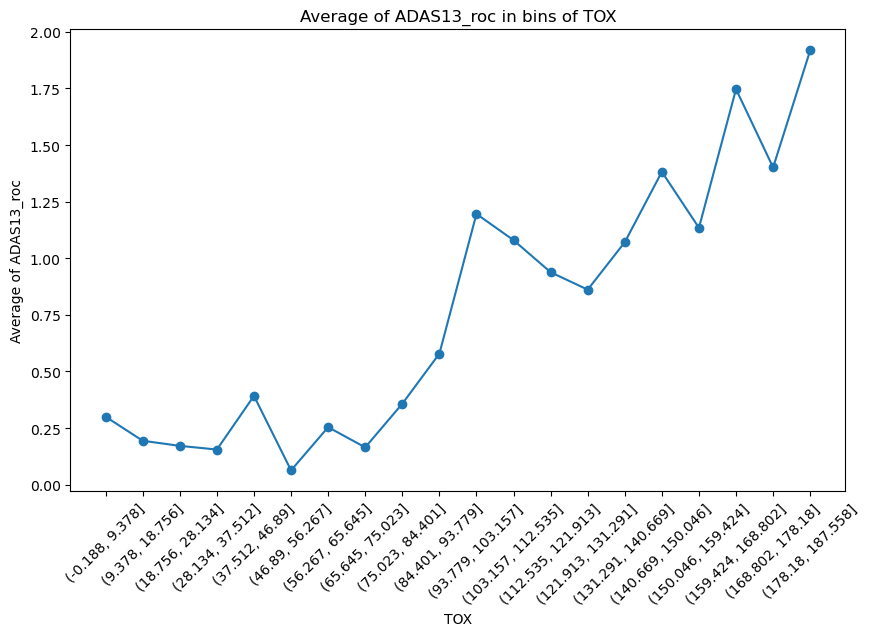

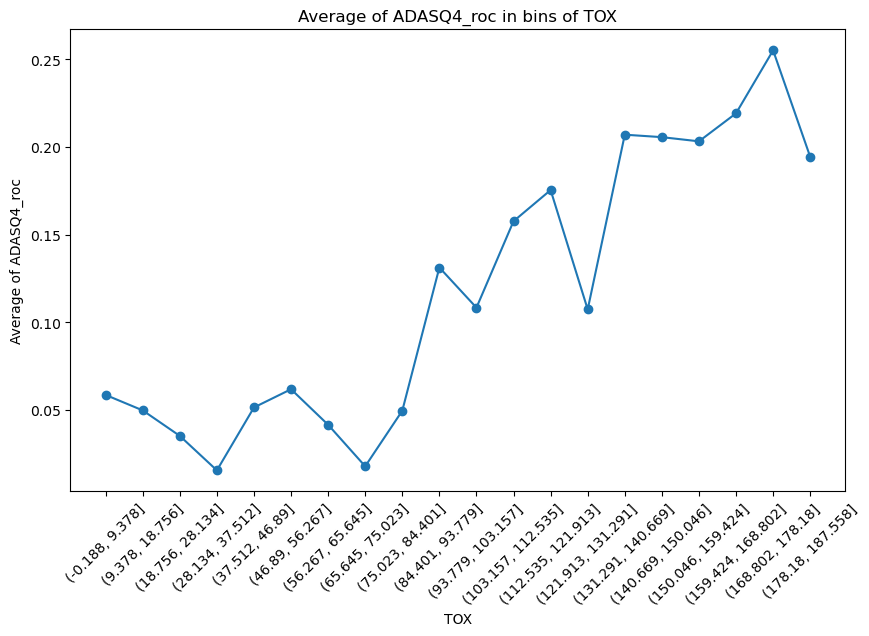

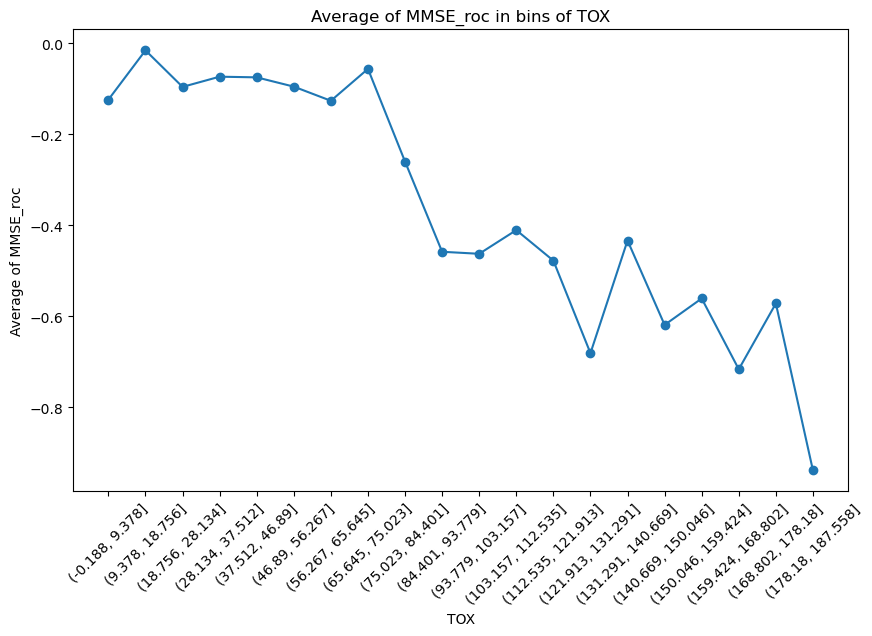

In [14]:
# Loop over the roc_columns and plot medians in bins for each one
for col in roc_columns:
    plot_ave_in_bins(df_plot, 'TOX', col)

# ML model prediction

In [15]:
from sklearn.model_selection import train_test_split

df_clean = df_plot.dropna(subset=['ABETA'])

bio_roc_cols = ['FDG_roc', 'PET-CL_roc', 'ABETA_roc', 'TAU_roc', 'PTAU_roc']
cog_roc_cols = ['CDRSB_roc', 'ADAS11_roc', 'ADAS13_roc', 'ADASQ4_roc', 'MMSE_roc']
cols_to_drop = ['RID', 'EXAMDATE', 'DX_bl'] 
# + bio_roc_cols + cog_roc_cols

X = df_clean.drop(cols_to_drop, axis=1)
y = df_clean['DX_bl']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

df_clean = df_plot.dropna(subset=['ABETA'])
cols_to_drop = ['RID', 'EXAMDATE', 'DX_bl'] 
# + bio_roc_cols + cog_roc_cols

X = df_clean.drop(cols_to_drop, axis=1)
y = df_clean['DX_bl']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

# train = df_plot.dropna(subset=['ABETA']).drop(['RID', 'EXAMDATE'], axis=1)

# Target columns
target_cols = ['DX_bl']

# Features
features = ['AGE', 'PTGENDER', 'PTEDUCAT', 'APOE4', 'FDG', 'PET-CL', 'ABETA', 'TAU',
           'PTAU', 'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE', 'FDG_roc',
           'PET-CL_roc', 'ABETA_roc', 'TAU_roc', 'PTAU_roc', 'CDRSB_roc',
           'ADAS11_roc', 'ADAS13_roc', 'ADASQ4_roc', 'MMSE_roc']

# Create models for each target
models = {
    'xgb': {target: XGBClassifier(n_estimators=1000, n_jobs=-1, max_depth=4, eta=0.2, colsample_bytree=0.67) for target in target_cols},
    'lgb': {target: LGBMClassifier(n_estimators=1000, n_jobs=-1, max_depth=4, learning_rate=0.2, colsample_bytree=0.67) for target in target_cols},
    'cat': {target: CatBoostClassifier(n_estimators=1000, depth=4, learning_rate=0.2, verbose=0) for target in target_cols}
}

# Dictionaries to store results
oof = {model: {target: [] for target in target_cols} for model in models.keys()}
auc_scores = {model: {target: [] for target in target_cols} for model in models.keys()}
best_iters = {model: {target: [] for target in target_cols} for model in models.keys()}
best_models = {model: {target: None for target in target_cols} for model in models.keys()}
best_auc = {model: {target: 0 for target in target_cols} for model in models.keys()}

# Training parameters
FOLDS = 10
SEED = 1004
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

# Train models
for model_name, model_dict in models.items():
    print(f'\033[1;34mTraining {model_name} models\033[0m')  # Blue for model names
    for target in target_cols:
        print(f'\033[1;32mTraining model for {target}\033[0m')  # Green for targets
        y = train[target]
        for fold, (train_idx, val_idx) in enumerate(skf.split(train, y)):
            print(f'\033[1;33m######################## Training FOLD {fold+1} ########################\033[0m')  # Yellow for fold numbers
            X_train, y_train = train.iloc[train_idx][features], y.iloc[train_idx]
            X_valid, y_valid = train.iloc[val_idx][features], y.iloc[val_idx]
            model = model_dict[target]
            model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)
            val_preds = model.predict_proba(X_valid)
            val_score = roc_auc_score(y_valid, val_preds, multi_class='ovo')
            print(f'\033[1;35mauc: {val_score:.5f}\033[0m')  # Purple for AUC scores
            oof[model_name][target].append(val_preds)
            auc_scores[model_name][target].append(val_score)
            if model_name == 'xgb':  # XGBoost
                best_iters[model_name][target].append(model.get_booster().best_ntree_limit)
            elif model_name == 'lgb':  # LightGBM
                best_iters[model_name][target].append(model.best_iteration_)
            # Save the best model
            if val_score > best_auc[model_name][target]:
                best_auc[model_name][target] = val_score
                best_models[model_name][target] = model
        print(f'\033[1;31m*********************************************\033[0m')  # Red for separator
        print(f'\033[1;35mMean AUC for {target}: {np.mean(auc_scores[model_name][target]):.5f}\033[0m')  # Purple for mean AUC scores

Training xgb models
Training model for DX_bl
######################## Training FOLD 1 ########################
auc: 0.86473
######################## Training FOLD 2 ########################
auc: 0.91632
######################## Training FOLD 3 ########################
auc: 0.88250
######################## Training FOLD 4 ########################
auc: 0.93165
######################## Training FOLD 5 ########################
auc: 0.91781
######################## Training FOLD 6 ########################
auc: 0.93796
######################## Training FOLD 7 ########################
auc: 0.89656
######################## Training FOLD 8 ########################
auc: 0.86175
######################## Training FOLD 9 ########################
auc: 0.91053
######################## Training FOLD 10 ########################
auc: 0.88438
*********************************************
Mean AUC for DX_bl: 0.90042
Training lgb models
Training model for DX_bl
######################## Training FOLD 1 ####

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



auc: 0.86392
######################## Training FOLD 2 ########################


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



auc: 0.91204
######################## Training FOLD 3 ########################


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



auc: 0.88396
######################## Training FOLD 4 ########################


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



auc: 0.92786
######################## Training FOLD 5 ########################


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



auc: 0.91129
######################## Training FOLD 6 ########################


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



auc: 0.93381
######################## Training FOLD 7 ########################


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



auc: 0.88837
######################## Training FOLD 8 ########################


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



auc: 0.85496
######################## Training FOLD 9 ########################


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



auc: 0.89489
######################## Training FOLD 10 ########################


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



auc: 0.87099
*********************************************
Mean AUC for DX_bl: 0.89421
Training cat models
Training model for DX_bl
######################## Training FOLD 1 ########################
auc: 0.88792
######################## Training FOLD 2 ########################
auc: 0.93818
######################## Training FOLD 3 ########################
auc: 0.89624
######################## Training FOLD 4 ########################
auc: 0.93191
######################## Training FOLD 5 ########################
auc: 0.93828
######################## Training FOLD 6 ########################
auc: 0.95060
######################## Training FOLD 7 ########################
auc: 0.90568
######################## Training FOLD 8 ########################
auc: 0.88304
######################## Training FOLD 9 ########################
auc: 0.92442
######################## Training FOLD 10 ########################
auc: 0.89458
*********************************************
Mean AUC for DX_bl: 0.91509


In [17]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.preprocessing import label_binarize

# get the unique labels
unique_labels = np.sort(train[target].unique())
n_classes = len(unique_labels)

# Binarize the output
y = label_binarize(train[target], classes=unique_labels)

# Initialize variables for fpr, tpr, and roc_auc
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
for model_name, model_dict in best_models.items():
    for i in range(n_classes):
        # make predictions for the given class
        binary_preds = model_dict[target].predict_proba(train[features])[:, i]  # get the probability of the class
        # Compute ROC curve and area under the curve
        fpr[i], tpr[i], _ = roc_curve(y[:, i], binary_preds)
        roc_auc[i] = auc(fpr[i], tpr[i])

Visualization for xgb DX_bl
Visualization for lgb DX_bl
Visualization for cat DX_bl


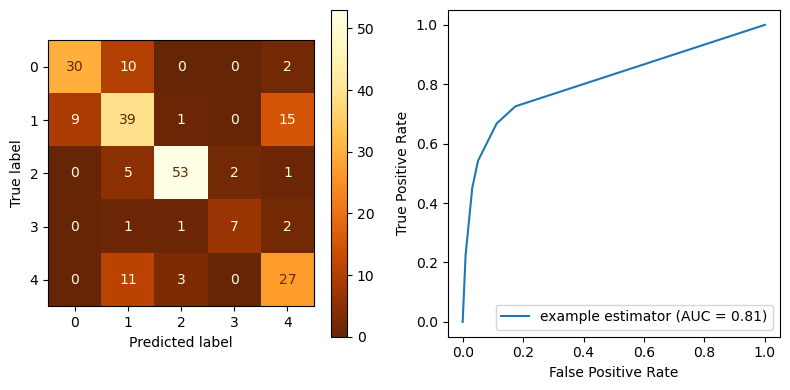

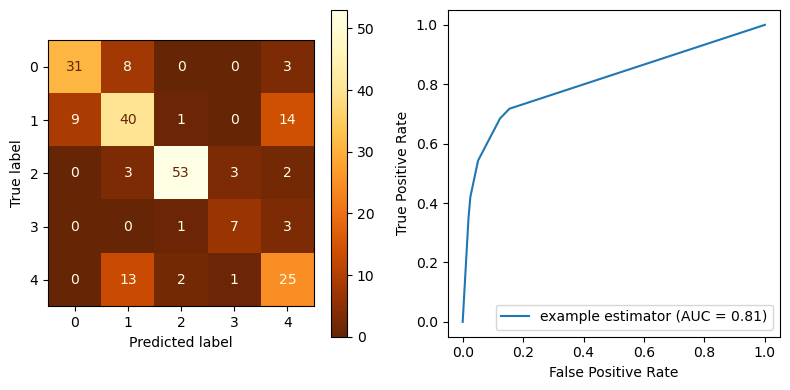

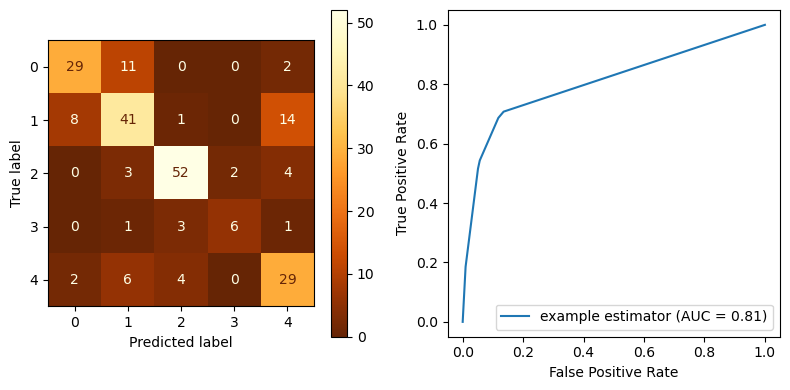

In [21]:
def show_confusion_roc(preds: np.array, target: np.array, classes: np.array) -> None:
    """Draws a confusion matrix and ROC curve with AUC score.
        
        Args:
            preds: Predictions from the model.
            target: True labels.
            classes: Unique classes in the target.
        
        Returns:
            None
    """
    f, ax = plt.subplots(1, 2, figsize=(8, 4))
    cm = confusion_matrix(target, preds)
    # Get sorted indices of classes
    sorted_indices = np.argsort(classes)

    # Sort classes
    classes_sorted = np.array(classes)[sorted_indices]

    # Sort rows and columns of confusion matrix based on sorted_indices
    cm_sorted = cm[:, sorted_indices][sorted_indices, :]

    # Now you can plot your sorted confusion matrix
    cm_display = ConfusionMatrixDisplay(cm_sorted, display_labels=classes_sorted).plot(cmap='YlOrBr_r', ax=ax[0])
    ax[0].grid(False)


    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_test = label_binarize(target, classes=classes)
    y_score = label_binarize(preds, classes=classes)

    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(classes)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= len(classes)

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    RocCurveDisplay(fpr=fpr["macro"], tpr=tpr["macro"], roc_auc=roc_auc["macro"], 
                    estimator_name='example estimator').plot(ax=ax[1])

    plt.tight_layout()

# for model_name, model_dict in best_models.items():
#     for target in target_cols:
#         print(f'\033[1;34;4mVisualization for {model_name} {target}\033[0m')  # Blue with underline for model and target
#         best_val_preds = np.argmax(model_dict[target].predict_proba(train[features]), axis=1)
#         show_confusion_roc(best_val_preds, train[target], train[target].unique())

for model_name, model_dict in best_models.items():
    for target in target_cols:
        print(f'\033[1;34;4mVisualization for {model_name} {target}\033[0m')  # Blue with underline for model and target
        best_val_preds = np.argmax(model_dict[target].predict_proba(test[features]), axis=1)
        show_confusion_roc(best_val_preds, test[target], test[target].unique())

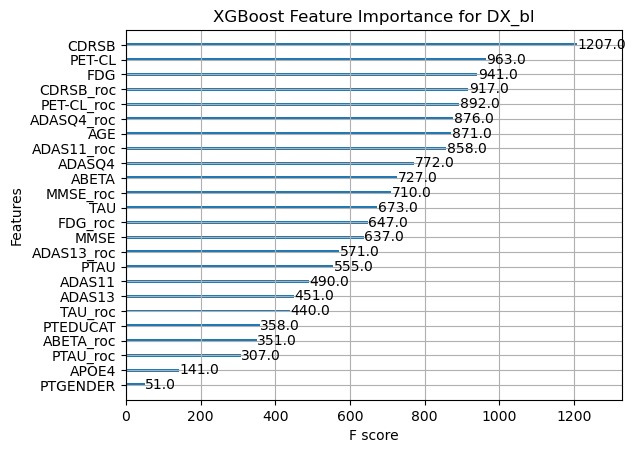

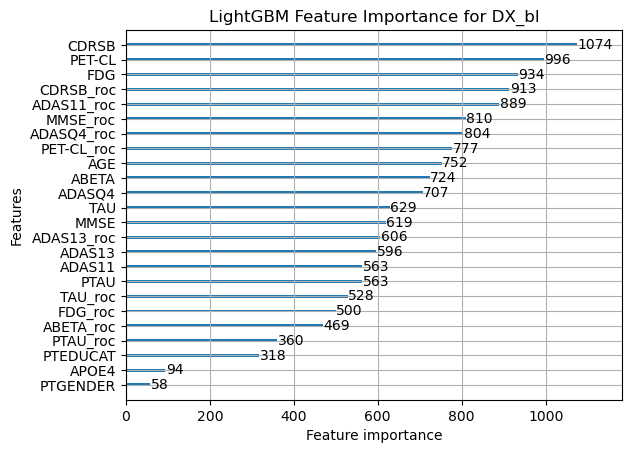

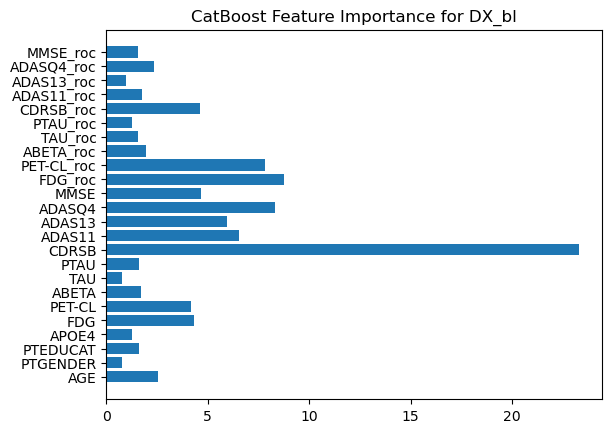

In [19]:
from xgboost import plot_importance
from xgboost import to_graphviz
import lightgbm as lgb

for target in target_cols:
    model = best_models['xgb'][target]
    plot_importance(model)
    plt.title(f"XGBoost Feature Importance for {target}")
    plt.show()
    
# for target in target_cols:
#     model = best_models['xgb'][target]
#     # Visualize the first tree
#     to_graphviz(model, num_trees=0)

for target in target_cols:
    model = best_models['lgb'][target]
    lgb.plot_importance(model)
    plt.title(f"LightGBM Feature Importance for {target}")
    plt.show()

# Assuming 'cat' is your trained CatBoost model
for target in target_cols:
    model = best_models['cat'][target]
    feature_importances = model.get_feature_importance()
    plt.barh(features, feature_importances)
    plt.title(f"CatBoost Feature Importance for {target}")
    plt.show()

In [20]:
import shap

target = target_cols[0]
model = best_models['xgb'][target]

# Create object that can calculate shap values
explainer = shap.Explainer(model)

# Calculate Shap values
shap_values = explainer(X_test)

# Get the number of classes from the shape of shap_values
num_classes = shap_values.values.shape[-1]

# Plot the SHAP values for each class
for i in range(num_classes):
    shap.summary_plot(shap_values[..., i], X_test, show=False)
    plt.title(f'SHAP Summary for Class {i}')  # Add title using pyplot
    plt.show()  # Use plt.show() to show each plot separately

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


ValueError: This reshape error is often caused by passing a bad data matrix to SHAP. See https://github.com/slundberg/shap/issues/580